In [3]:
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import numpy as np

In [8]:
conn = psycopg2.connect('dbname=cpdp user=blaine password=postgres')
cur = conn.cursor()

In [10]:
# Create Subset view
cur.execute('''
    CREATE TEMP VIEW officer_subset AS
    SELECT o.id, o.first_name, o.last_name, o.birth_year, o.appointed_date,
          date_part('year', '2018-01-01'::DATE) - o.birth_year as estimated_age,
          ('2018-01-01'::DATE - o.appointed_date) / 365 as years_on_force,
          COUNT(a.id) as allegation_count
    FROM data_officer o
    LEFT JOIN data_officerallegation a on o.id = a.officer_id
    WHERE active = 'Yes'
        AND appointed_date BETWEEN '2000-01-01' AND '2007-12-31'
    GROUP BY o.id
    ORDER BY years_on_force DESC;
''')

In [11]:
# create city settlement view
cur.execute('''
    CREATE TEMP VIEW officer_subsetsettlementpayment AS
    SELECT o.id as officer_id, payment.id as payment_id
        FROM officer_subset o
    INNER JOIN cop_officer_map cop ON cop.officer_id = o.id
    INNER JOIN cops_casecop case_cop ON case_cop.cop_id = cop.cop_id
    INNER JOIN cases_case case_case ON case_case.id = case_cop.case_id
    INNER JOIN cases_payment payment ON payment.case_id = case_case.id;
''')

In [12]:
# create civil cases view
cur.execute('''
    CREATE TEMP VIEW officer_subsetcivilcase AS
    SELECT o.id as officer_id, civil_case.id as civil_case_id
        FROM officer_subset o
    INNER JOIN data_officerallegation officerallegation ON officerallegation.officer_id = o.id
    INNER JOIN case_map ON case_map.allegation_id = officerallegation.allegation_id
    INNER JOIN cases_ipracase civil_case ON civil_case.id = case_map.case_id;
''')

In [13]:
settlement_df = pd.read_sql_query('''
SELECT years_on_force, AVG(allegation_count) as avg_allegation_count, AVG(payment_count) as avg_settlement_count, AVG(payment_total) as average_settlement_amount
FROM (
    SELECT officer_subset.id,
           officer_subset.years_on_force as years_on_force,
           officer_subset.allegation_count as allegation_count,
           COUNT(payment.id) as payment_count,
           COALESCE(SUM(payment.payment),0) as payment_total
    FROM officer_subset
    LEFT JOIN officer_subsetsettlementpayment as payment_map ON payment_map.officer_id = officer_subset.id
    LEFT JOIN cases_payment payment ON payment.id = payment_map.payment_id
    GROUP by officer_subset.id, officer_subset.years_on_force, officer_subset.allegation_count
    HAVING COUNT(payment.id) > 0
    ORDER BY payment_total DESC
) as settlement_aggregate
GROUP BY years_on_force;
''', con=conn)

In [15]:
no_settlement_df = pd.read_sql_query('''
SELECT years_on_force, AVG(allegation_count) as avg_allegation_count, AVG(payment_count) as avg_settlement_count, AVG(payment_total) as average_settlement_amount
FROM (
    SELECT officer_subset.id,
           officer_subset.years_on_force as years_on_force,
           officer_subset.allegation_count as allegation_count,
           COUNT(payment.id) as payment_count,
           COALESCE(SUM(payment.payment),0) as payment_total
    FROM officer_subset
    LEFT JOIN officer_subsetsettlementpayment as payment_map ON payment_map.officer_id = officer_subset.id
    LEFT JOIN cases_payment payment ON payment.id = payment_map.payment_id
    GROUP by officer_subset.id, officer_subset.years_on_force, officer_subset.allegation_count
    HAVING COUNT(payment.id) = 0
    ORDER BY payment_total DESC
) as settlement_aggregate
GROUP BY years_on_force;
''', con=conn)

In [32]:
civil_case_df = pd.read_sql_query('''
SELECT years_on_force, AVG(allegation_count) as avg_allegation_count, AVG(case_count) as avg_civil_case_count
FROM (
    SELECT officer_subset.id,
           officer_subset.years_on_force as years_on_force,
           officer_subset.allegation_count as allegation_count,
           COUNT(civil_case.civil_case_id) as case_count
    FROM officer_subset
    LEFT JOIN officer_subsetcivilcase civil_case ON civil_case.officer_id = officer_subset.id
    GROUP by officer_subset.id, officer_subset.years_on_force, officer_subset.allegation_count
    HAVING COUNT(civil_case.civil_case_id) > 0
) as settlement_aggregate
GROUP BY years_on_force;
''', con=conn)

In [33]:
no_civil_case_df = pd.read_sql_query('''
SELECT years_on_force, AVG(allegation_count) as avg_allegation_count, AVG(case_count) as avg_civil_case_count
FROM (
    SELECT officer_subset.id,
           officer_subset.years_on_force as years_on_force,
           officer_subset.allegation_count as allegation_count,
           COUNT(civil_case.civil_case_id) as case_count
    FROM officer_subset
    LEFT JOIN officer_subsetcivilcase civil_case ON civil_case.officer_id = officer_subset.id
    GROUP by officer_subset.id, officer_subset.years_on_force, officer_subset.allegation_count
    HAVING COUNT(civil_case.civil_case_id) = 0
) as settlement_aggregate
GROUP BY years_on_force;
''', con=conn)

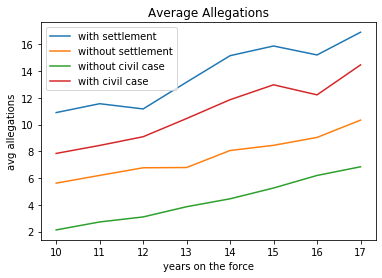

In [36]:
yrs = no_settlement_df['years_on_force']

no_ac = no_settlement_df['avg_allegation_count']
ac = settlement_df['avg_allegation_count']

no_cc = no_civil_case_df['avg_allegation_count']
cc = civil_case_df['avg_allegation_count']

plt.plot(yrs, ac, label="with settlement")
plt.plot(yrs, no_ac, label="without settlement")
plt.plot(yrs, no_cc, label="without civil case")
plt.plot(yrs, cc, label="with civil case")

plt.title('Average Allegations')
plt.xlabel('years on the force')
plt.ylabel('avg allegations')
plt.legend()

plt.savefig('images/q1_average_allegations')